# ClusterEnsemble demonstration
Some example usage of how to build up a dataframe of galaxy cluster properties, including NFW halo profiles. Each cluster is treated as an individual, meaning we track its individual mass and redshift, and other properties. This is useful for fitting a stacked weak lensing profile, for example, where you want to avoid fitting a single average cluster mass. See the project [documentation](http://jesford.github.io/cluster-lensing/index.html) for more details.

In [1]:
from __future__ import print_function

import numpy as np
from astropy import units
from matplotlib import pyplot as plt

%matplotlib inline

from clusterlensing import ClusterEnsemble

### Create a ClusterEnsemble object by passing in a numpy array (or list) of redshifts

In [2]:
z = [0.1,0.2,0.3]
c = ClusterEnsemble(z)
c.describe

'Ensemble of galaxy clusters and their properties.'

### Display what we have so far
Below the DataFrame (which so far only contains the cluster redshifts), we see the default assumptions for the power-law slope and normalization that will be used to convert richness $N_{200}$ to mass $M_{200}$. We'll see how to change those parameters below.

In [3]:
c.show()


Cluster Ensemble:


,z
0,0.1
1,0.2
2,0.3



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Add richness values to the dataframe
This step will also generate $M_{200}$, $r_{200}$, $c_{200}$, scale radius $r_s$, and other parameters, assuming the scaling relation given below.

In [4]:
n200 = np.ones(3)*20.
c.n200 = n200
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.1,20,2.700000e+13,0.612222,5.839934,12421.201995,0.104834
1,0.2,20,2.700000e+13,0.591082,5.644512,11480.644557,0.104718
2,0.3,20,2.700000e+13,0.569474,5.442457,10555.781440,0.104636



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Access any column of the dataframe as an array
Notice that [astropy units](http://docs.astropy.org/en/stable/units/) are present for the appropriate columns.

In [5]:
print('z: \t', c.z)
print('n200: \t', c.n200)
print('r200: \t', c.r200)
print('m200: \t', c.m200)
print('c200: \t', c.c200)
print('rs: \t', c.rs)

z: 	 [ 0.1  0.2  0.3]
n200: 	 [ 20.  20.  20.]
r200: 	 [ 0.61222163  0.59108187  0.56947428] Mpc
m200: 	 [  2.70000000e+13   2.70000000e+13   2.70000000e+13] solMass
c200: 	 [ 5.8399338   5.64451215  5.44245689]
rs: 	 [ 0.10483366  0.10471797  0.10463552] Mpc


### If you don't want units, you can get just the values

In [6]:
c.r200.value

array([ 0.61222163,  0.59108187,  0.56947428])

### Or access the Pandas DataFrame directly

In [7]:
c.dataframe

,z,n200,m200,r200,c200,delta_c,rs
0,0.1,20,2.700000e+13,0.612222,5.839934,12421.201995,0.104834
1,0.2,20,2.700000e+13,0.591082,5.644512,11480.644557,0.104718
2,0.3,20,2.700000e+13,0.569474,5.442457,10555.781440,0.104636


### Change the redshifts
These changes will propogate to all redshift-dependant cluster attributes.

In [8]:
c.z = np.array([0.4,0.5,0.6])
c.dataframe

,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.244512,9695.735436,0.104457
1,0.5,20,2.700000e+13,0.526483,5.055666,8916.795783,0.104137
2,0.6,20,2.700000e+13,0.505701,4.878356,8221.639808,0.103662


### Change the mass or richness values
Changing mass will affect richness and vice-versa, through the mass-richness scaling relation. These changes will propogate to all mass-dependant cluster attributes, as appropriate. 

In [9]:
c.m200 = [3e13,2e14,1e15]
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,21.563235,3.000000e+13,0.567408,5.194688,9486.316304,0.109229
1,0.5,83.602673,2.000000e+14,1.026296,4.238847,5994.835515,0.242117
2,0.6,263.927382,1.000000e+15,1.685668,3.583538,4142.243702,0.470392



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


In [10]:
c.n200 = [20,30,40]
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.244512,9695.735436,0.104457
1,0.5,30,4.763120e+13,0.636151,4.809323,7960.321226,0.132274
2,0.6,40,7.125343e+13,0.698834,4.490373,6819.417449,0.155629



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Change the parameters in the mass-richness relation
The mass-richness slope and normalization can both be changed. The new parameters will be applied to the current n200, and will propagate to mass and other dependant quantities.

In [11]:
c.massrich_slope = 1.5
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.244512,9695.735436,0.104457
1,0.5,30,4.960217e+13,0.644807,4.792194,7896.280856,0.134554
2,0.6,40,7.636753e+13,0.715169,4.463870,6729.455181,0.160213



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


In [12]:
# Show basic table without Pandas formatting
c.show(notebook = False)


Cluster Ensemble:
     z  n200          m200      r200      c200      delta_c        rs
0  0.4    20  2.700000e+13  0.547827  5.244512  9695.735436  0.104457
1  0.5    30  4.960217e+13  0.644807  4.792194  7896.280856  0.134554
2  0.6    40  7.636753e+13  0.715169  4.463870  6729.455181  0.160213

Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


## Calculate $\Sigma(r)$ and $\Delta\Sigma(r)$ for NFW model
First select the radial bins in units of Mpc.

In [13]:
rmin, rmax = 0.1, 5. # Mpc
nbins = 20
rbins = np.logspace(np.log10(rmin), np.log10(rmax), num = nbins)
print('rbins range from', rbins.min(), 'to', rbins.max(), 'Mpc')

rbins range from 0.1 to 5.0 Mpc


In [14]:
c.calc_nfw(rbins)    # calculate the profiles

sigma = c.sigma_nfw  # access the profiles
deltasigma = c.deltasigma_nfw

In [15]:
sigma[0]

<Quantity [ 139.4116229 , 108.34791832,  82.77115926,  62.19065202,
             45.99737488,  33.52554303,  24.10990324,  17.13059635,
             12.04197196,   8.38587358,   5.79256563,   3.97346101,
              2.70954262,   1.83845763,   1.24220137,   0.83639739,
              0.56152963,   0.37608786,   0.25138828,   0.16776142] solMass / pc2>

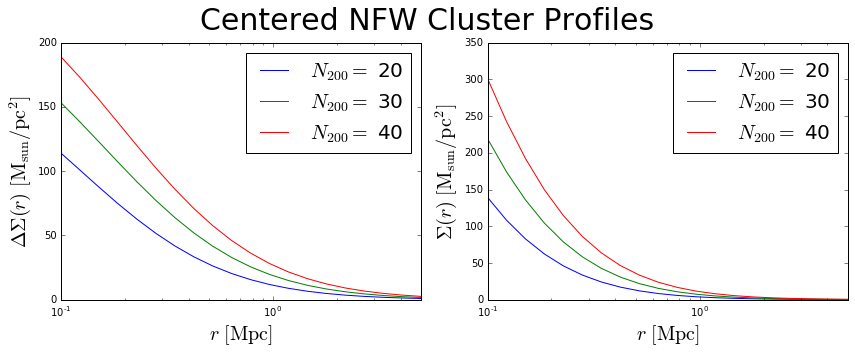

In [16]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Centered NFW Cluster Profiles', size=30)

first = fig.add_subplot(1,2,1)
second = fig.add_subplot(1,2,2)

for rich, profile in zip(c.n200,deltasigma):
    first.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
first.set_xscale('log')
first.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
first.set_ylabel('$\Delta\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', 
                 fontsize=20)
first.set_xlim(rbins.min(), rbins.max())
first.legend(fontsize=20)


for rich, profile in zip(c.n200,sigma):
    second.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
second.set_xscale('log')
second.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
second.set_ylabel('$\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', 
                 fontsize=20)
second.set_xlim(0.05, 1.)
second.set_xlim(rbins.min(), rbins.max())
second.legend(fontsize=20)


fig.tight_layout()
plt.subplots_adjust(top=0.88)

# Calculate Miscentered NFW Profiles

When the true underlying dark matter distribution is offset from the assumed cluster "center" (such as a BCG or some other center proxy), the weak lensing profiles measured around the assumed centers will be different than for the perfectly centered case. One way to account for this is to describe the cluster centroid offsets as a Gaussian distribution around the true centers. We say the probability of an offset is given by

$P(R_\mathrm{off}) = \frac{R_\mathrm{off}}{\sigma_\mathrm{off}^2}e^{-\frac{1}{2}\left(\frac{R_\mathrm{off}}{\sigma_\mathrm{off}}\right)^2}$,

which is parameterized by the width of the 2D offset distribution $\sigma_\mathrm{off} = \sqrt{\sigma_x^2 + \sigma_y^2}$. Then the measured surface mass density is given by 

$\Sigma^\mathrm{sm}(R) = \int_0^\infty \Sigma(R | R_\mathrm{off})\  P(R_\mathrm{off})\ \mathrm{d}R_\mathrm{off}$,

where

$\Sigma(R | R_\mathrm{off}) = \frac{1}{2\pi} \int_0^{2\pi} \Sigma(r')\ \mathrm{d}\theta$, 

and

$r' = \sqrt{R^2 + R_\mathrm{off}^2 - 2 R R_\mathrm{off} \cos{\theta}}$.

More details on the cluster miscentering problem can be found in [Ford et al 2015](http://arxiv.org/abs/1409.3571), [George et al 2012](http://arxiv.org/abs/1205.4262), and [Johnston et al 2007](http://arxiv.org/abs/0709.1159).

To calculate the miscentered profiles, simply create an array of offsets in units of Mpc, and pass it to the calc_nfw method:

In [17]:
offsets = np.array([0.1,0.1,0.1]) #same length as number of clusters

c.calc_nfw(rbins, offsets=offsets)

deltasigma_off = c.deltasigma_nfw
sigma_off = c.sigma_nfw

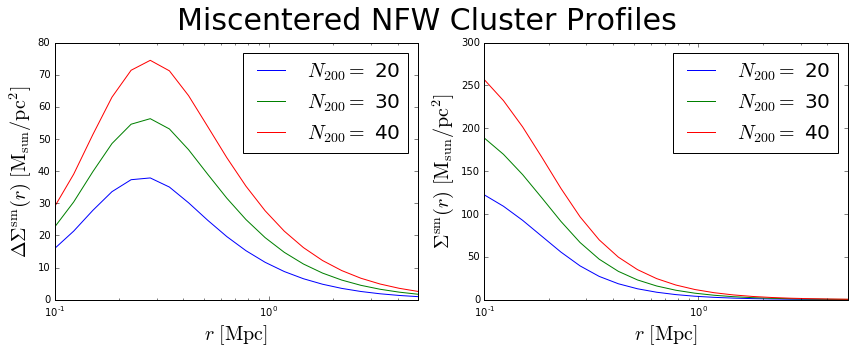

In [18]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Miscentered NFW Cluster Profiles', size=30)

first = fig.add_subplot(1,2,1)
second = fig.add_subplot(1,2,2)

for rich, profile in zip(c.n200,deltasigma_off):
    first.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
first.set_xscale('log')
first.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
ytitle = '$\Delta\Sigma^\mathrm{sm}(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$'
first.set_ylabel(ytitle, fontsize=20)
first.set_xlim(rbins.min(), rbins.max())
first.legend(fontsize=20)


for rich, profile in zip(c.n200,sigma_off):
    second.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
second.set_xscale('log')
second.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
ytitle = '$\Sigma^\mathrm{sm}(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$'
second.set_ylabel(ytitle, fontsize=20)
second.set_xlim(rbins.min(), rbins.max())
second.legend(fontsize=20)


fig.tight_layout()
plt.subplots_adjust(top=0.88)

### Advanced use: tuning the precision of the integrations
The centered profile calculations are straightforward, and this package uses the formulas given in [Wright & Brainerd 2000](http://adsabs.harvard.edu/abs/2000ApJ...534...34W) for this. However, as outlined above, the calculation of the miscentered profiles requires a double integration for $\Sigma^\mathrm{sm}(R)$, and there is a third integration for calculating $\Delta\Sigma^\mathrm{sm}(R) = \overline{\Sigma^\mathrm{sm}}(< R) - \Sigma^\mathrm{sm}(R)$. 

For increased precision, you can adjust parameters specifying the number of bins to use in these integration (but note that this comes at the expense of increased computational time). See the [documentation](http://jesford.github.io/cluster-lensing/index.html) for details.